# Biden and Trump: Process and analyze press release metadata

> Use natural language processing techniques to infer topics from the headlines in each president's press releases.

---

## Config

#### Python tools and Jupyter settings

In [1]:
import os
import re
import nltk
import json
import requests
import googlemaps
import numpy as np
import pandas as pd
import jupyter_black
import altair as alt
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import plotly.graph_objects as go
from nltk.tokenize import word_tokenize, MWETokenizer

In [2]:
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")
# nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [3]:
google_key = os.environ.get("GOOGLE_GEOCODER")

In [4]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

In [5]:
today = pd.Timestamp("today").strftime("%Y-%m-%d")
presidents = ["biden", "trump"]

---

## Read data

#### File paths to metadata collected on each president's press releases

In [6]:
biden_metadata_path = "../data/processed/biden/biden_release_metadata.csv"
trump_metadata_path = "../data/processed/trump/trump_release_metadata.csv"

#### Reading CSV files

In [7]:
biden_df = pd.read_csv(biden_metadata_path, parse_dates=["date"])
trump_df = pd.read_csv(trump_metadata_path, parse_dates=["date"])

#### Concatenate DataFrames

In [8]:
src = pd.concat([biden_df, trump_df], ignore_index=True)

#### Function to remove non-ASCII characters

In [9]:
def remove_non_ascii(text):
    return re.sub(r"[^\x00-\x7F]+", " ", text)

#### Apply this function to the headlines

In [10]:
src["headline"] = src["headline"].apply(remove_non_ascii)

#### How many releases?

In [11]:
src.president.value_counts().reset_index()

,president,count
0,biden,9922
1,trump,8478


In [12]:
total_releases = len(src)
total_releases

18400

In [13]:
df = src.copy()

#### Filter the remaining analysis so it just applies to remarks by each president

In [14]:
df["president_remarks"] = df["headline"].str.contains("Remarks by President")

In [15]:
remarks_df = df[df["headline"].str.contains("Remarks by President")].copy()

In [16]:
remarks_df.president.value_counts().reset_index()

,president,count
0,trump,1383
1,biden,1271


---

## Processing

#### Biden's release don't have `issue_flag` text, and Trump's are occasionally incomplete

In [17]:
df["issue_flag"] = df["issue_flag"].fillna("Not specified")

#### They use slightly different categories. Map original ones to derived ones.

In [18]:
category_mapping = {
    "Speeches and Remarks": ["Speeches and Remarks", "Remarks"],
    "Statements and Releases": [
        "Statements and Releases",
        "Statements & Releases",
        "Fact Sheets",
        "News Clips",
    ],
    "Presidential Actions": [
        "Presidential Actions",
        "Executive Orders",
        "Presidential Memoranda",
        "Proclamations",
    ],
    "Legislation and Policy": ["Legislation", "Not specified"],
    "Press and Media": ["Press Briefings", "Nominations & Appointments", "Blog"],
    "Transparency and Governance": ["Disclosures"],
}

#### Function to map original categories to derived categories

In [19]:
def map_to_derived_category(original_category):
    for derived, originals in category_mapping.items():
        if original_category in originals:
            return derived
    return "Other"  # Default category if no match is found

#### Apply the mapping

In [20]:
df["derived_category"] = df["category"].apply(map_to_derived_category)

---

## Extraction

### Location

#### How many releases list a location? What share of all of them? 

In [21]:
releases_w_location = len(df[df["location"].notnull()])
releases_w_location

638

In [22]:
round((releases_w_location / total_releases) * 100, 1)

3.5

#### Geocode the locations, even though they are incomplete

In [23]:
gmaps = googlemaps.Client(key=google_key)

In [24]:
def geocode_location(location):
    """Geocode a location string using Google Maps API and return lat, lon coordinates."""
    try:
        # Make sure the gmaps client is correctly referenced and used here
        geocode_result = gmaps.geocode(location)

        if geocode_result and len(geocode_result) > 0:
            lat = geocode_result[0]["geometry"]["location"]["lat"]
            lon = geocode_result[0]["geometry"]["location"]["lng"]
            return lat, lon
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

#### Add empty columns for latitude and longitude if they don't exist

In [25]:
if "latitude" not in df.columns:
    df["latitude"] = None
if "longitude" not in df.columns:
    df["longitude"] = None

#### Iterate through DataFrame rows and apply geocoding for non-null locations

In [26]:
for index, row in tqdm(
    df[df["location"].notnull()].iterrows(), total=df["location"].notnull().sum()
):

    lat, lon = geocode_location(row["location"])
    df.at[index, "latitude"] = lat
    df.at[index, "longitude"] = lon

  0%|          | 0/638 [00:00<?, ?it/s]

### Keywords

#### Function to clean and extract keywords from a headline

In [27]:
def extract_keywords(headline):
    # Lowercase and remove non-alphabetic characters
    headline = re.sub(r"[^a-zA-Z\s]", "", headline.lower())

    # Tokenize the headline
    tokens = word_tokenize(headline)

    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words("english")]

    # Tag parts of speech
    tags = nltk.pos_tag(tokens)

    # Extract nouns
    keywords = [word for word, tag in tags if tag in ["NN", "NNS", "NNP", "NNPS"]]

    return keywords

#### Apply keyword extraction to each headline

In [28]:
df["keywords"] = df["headline"].apply(extract_keywords)

#### Example: Display the first few entries to verify

In [29]:
df.keywords.sample(5)

6198                                                                                                           [nominations, senate]
5856                                                                                                [proclamation, americans, covid]
10445                                                                                         [remarks, president, press, september]
7912     [statement, advisor, chief, spokesperson, symone, sanders, vice, president, call, security, secretary, alejandro, mayorkas]
7858                                                                        [president, joseph, r, biden, jr, disaster, declaration]
Name: keywords, dtype: object

### Count keywords

#### Define additional stop words specific to this context

In [30]:
additional_stopwords = [
    "president",
    "biden",
    "trump",
    "harris",
    "pence",
    "vice",
    "jill",
    "lady",
    "joe",
    "joseph",
    "trump",
    "donald",
    "presidential",
    "remarks",
    "release",
    "statement",
    "proclamation",
    "declaration",
    "announces",
    "press",
    "senior",
    "secretary",
    "national",
    "readout",
    "fact",
    "sheet",
    "security",
    "white",
    "house",
    "administration",
    "advisor",
    "briefing",
    "minister",
    "prime",
    "jen",
    "psaki",
    "jake",
    "sullivan",
    "executive",
    "call",
    "united",
    "states",
    "karine",
    "jill",
    "spokesperson",
]

#### Combine nltk's English stopwords with your additional ones

In [31]:
stop_words = set(stopwords.words("english")).union(set(additional_stopwords))

In [32]:
def get_keywords_by_president(president_name):
    # Filter dataframe by president and then concatenate all headlines into a single string
    headlines = " ".join(
        df[df["president"].str.lower() == president_name.lower()]["headline"].tolist()
    )

    # Tokenize the headlines and filter out stopwords and non-alphabetic characters
    tokens = [
        word.lower()
        for word in word_tokenize(headlines)
        if word.isalpha() and word.lower() not in stop_words
    ]

    # Count word frequency
    word_counts = Counter(tokens)

    # Return the common words
    return word_counts.most_common(50)

#### Count the keywords

In [33]:
biden_keywords = get_keywords_by_president("Biden")
trump_keywords = get_keywords_by_president("Trump")

#### Create a dataframe for each president's keywords

In [34]:
df_biden = pd.DataFrame(biden_keywords, columns=["keyword", "count"])
df_biden["president"] = "biden"
df_trump = pd.DataFrame(trump_keywords, columns=["keyword", "count"])
df_trump["president"] = "trump"

#### Concatenate the two, filtering only to words both administrations used

In [35]:
total_releases_biden = df[df["president"].str.lower() == "biden"].shape[0]
total_releases_trump = df[df["president"].str.lower() == "trump"].shape[0]

df_keywords = (
    pd.concat([df_biden, df_trump], ignore_index=True)
    .pivot_table(index="keyword", values="count", columns="president")
    .reset_index()
    .dropna()
    .reset_index(drop=True)
)
# Normalize the counts
df_keywords["biden_normalized"] = (
    (df_keywords["biden"] / total_releases_biden) * 100
).round(2)
df_keywords["trump_normalized"] = (
    (df_keywords["trump"] / total_releases_trump) * 100
).round(2)

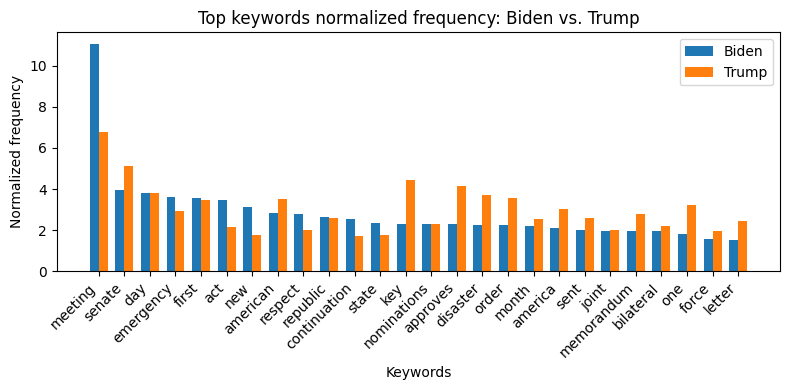

In [36]:
# Assuming df_keywords is your DataFrame and it contains the normalized counts for Biden and Trump
top_keywords = df_keywords.sort_values(by="biden_normalized", ascending=False)

# Creating indices for the x-axis positions
x_indices = np.arange(len(top_keywords))

# Bar width
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting both Biden and Trump keyword frequencies
biden_bars = ax.bar(
    x_indices - bar_width / 2,
    top_keywords["biden_normalized"],
    bar_width,
    label="Biden",
)
trump_bars = ax.bar(
    x_indices + bar_width / 2,
    top_keywords["trump_normalized"],
    bar_width,
    label="Trump",
)

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel("Keywords")
ax.set_ylabel("Normalized frequency")
ax.set_title("Top keywords normalized frequency: Biden vs. Trump")
ax.set_xticks(x_indices)
ax.set_xticklabels(top_keywords["keyword"], rotation=45, ha="right")
ax.legend()

# Adding a legend and a tight layout
ax.legend()
plt.tight_layout()
plt.show()

### Counting vice presidential mentions

#### How many times did each presidential press release mention the vice president? 

In [37]:
df["headline_lower"] = df["headline"].str.lower()

#### Define keywords to search for in headlines

In [38]:
biden_vp_keywords = ["harris"]
trump_vp_keywords = ["pence"]

#### Count the total number of releases for each president

In [39]:
total_releases_biden = df[df["president"].str.lower() == "biden"].shape[0]
total_releases_trump = df[df["president"].str.lower() == "trump"].shape[0]

#### Function to count mentions and normalize by total releases

In [40]:
def count_vp_mentions_normalized(df, president_name, keywords):
    president_df = df[df["president"].str.lower() == president_name.lower()]
    mentions_count = (
        president_df["headline_lower"]
        .apply(lambda x: any(keyword.lower() in x for keyword in keywords))
        .sum()
    )
    total_releases = president_df.shape[0]
    return (
        mentions_count,
        total_releases,
        mentions_count / total_releases if total_releases > 0 else 0,
    )

#### Count and normalize mentions for each vice president

In [41]:
biden_vp_mentions, biden_total, biden_normalized = count_vp_mentions_normalized(
    df, "Biden", biden_vp_keywords
)
trump_vp_mentions, trump_total, trump_normalized = count_vp_mentions_normalized(
    df, "Trump", trump_vp_keywords
)

print(
    f"Vice President in Biden's press releases: {biden_vp_mentions} out of {biden_total} releases ({biden_normalized:.2%})"
)
print(
    f"Vice President in Trump's press releases: {trump_vp_mentions} out of {trump_total} releases ({trump_normalized:.2%})"
)

Vice President in Biden's press releases: 1437 out of 9922 releases (14.48%)
Vice President in Trump's press releases: 763 out of 8478 releases (9.00%)


---

## Export

#### All to CSV & JSON

In [42]:
df.to_csv(f"../data/processed/biden_trump_releases_metadata_keywords.csv", index=False)

In [43]:
df.to_json(
    f"../data/processed/biden_trump_releases_metadata_keywords.json",
    indent=4,
    orient="records",
)